In [ ]:
!pip install python-levenshtein

     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149862 sha256=acec5082b627f13f6334b471d91e50b35941242ff4c7a80ee99a88a3470505ed
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


# Libraries and Initial Processing

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import Levenshtein as lev
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from tqdm import tqdm

cuda = torch.cuda.is_available()

print(cuda, sys.version)

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))
np.random.seed(42)
torch.manual_seed(42)




# The labels of the dataset contain letters in LETTER_LIST.
# You should use this to convert the letters to the corresponding indices
# and train your model with numerical labels.
LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

True 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cuda = True with num_workers = 4


In [ ]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST

    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict()
    index2letter = dict()

    for i in range(len(letter_list)):
      letter2index[letter_list[i]] = i
      index2letter[i] = letter_list[i]

    # print(letter2index)
    # print(index2letter)

    # TODO
    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices):
    '''
    Transforms numerical index input to string output by converting each index 
    to its corresponding letter from LETTER_LIST

    Args:
        batch_indices: List of indices from LETTER_LIST with the shape of (N, )
    
    Return:
        transcripts: List of converted string transcripts. This would be a list with a length of N
    '''
    transcripts = []
    for i in batch_indices:
      transcripts.append(LETTER_LIST[i])
    return transcripts
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
print(letter2index)
print(index2letter)

{'<sos>': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, "'": 27, ' ': 28, '<eos>': 29}
{0: '<sos>', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z', 27: "'", 28: ' ', 29: '<eos>'}


# Kaggle (TODO)

In [ ]:
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"","key":""}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

!kaggle competitions download -c 11-785-s22-hw4p2
!unzip -q 11-785-s22-hw4p2.zip

!ls



     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=704249b171f2069a66691a3bcd6f42e8224bd75b88770959458300916a4066c0
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 99% 1.83G/1.84G [00:08<00:00, 236MB/s]
100% 1.84G/1.84G [00:09<00:00, 219MB/s]
11-785-s22-hw4p2.zip  hw4p2_simple  hw4p2_student_data	sample_data


# Dataset and Dataloading (TODO)

You will need to implement the Dataset class by your own. You can implement it similar to HW3P2. However, you are welcomed to do it your own way if it is more comfortable or efficient.

Note that you need to use LETTER_LIST to convert the transcript into numerical labels for the model.


Example of raw transcript:

    ['<sos>', 'N', 'O', 'R', 'T', 'H', 'A', 'N', 'G', 'E', 'R', ' ','A', 'B', 'B', 'E', 'Y', '<eos>']

Example of converted transcript ready to process for the model:

    [0, 14, 15, 18, 20, 8, 1, 14, 7, 5, 18, 28, 1, 2, 2, 5, 25, 29]


In [ ]:
class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train"):

      self.X_dir = data_path + "/" + partition + "/mfcc/" 
      self.Y_dir = data_path + "/" + partition +"/transcript/"

      self.X_files = os.listdir(self.X_dir) # TODO: list files in the mfcc directory
      self.Y_files = os.listdir(self.Y_dir) # TODO: list files in the transcript directory
      self.partition = partition


      # and train your model with numerical labels.
      LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

      self.LETTER_LIST = LETTER_LIST

        
      assert(len(self.X_files) == len(self.Y_files))

      pass


    def __len__(self):
      return len(self.X_files)

    def __getitem__(self, ind):
      X_path = self.X_dir+self.X_files[ind]
      Y_path = self.Y_dir+self.Y_files[ind]
        
      X = np.load(X_path)
      X_data = (X - X.mean(axis=0))/X.std(axis=0)
      # X_data = [self.LETTER_LIST.index(xx) for xx in np.load(X_path)[1:-1]]
      # if ind ==1 or ind ==2:
      #   print(np.load(Y_path))
      #   print(np.load(Y_path).shape)
        
      label = [self.LETTER_LIST.index(yy) for yy in np.load(Y_path)]
        
        
      Yy = torch.tensor(label).long() # TODO: Convert sequence of  phonemes into sequence of Long tensors
      # if ind == 1 or ind ==2:
      #   # print(X.shape)
      #   print(Yy.shape)
      #   print(Yy)

      return torch.tensor(X_data), Yy

    
    def collate_fn(batch):
      batch_x = [x for x,y in batch]
      batch_y = [y for x,y in batch]

      batch_x_pad = pad_sequence(batch_x,batch_first=True, padding_value=0)# TODO: pad the sequence with pad_sequence (already imported)
      lengths_x = [len(x) for x in batch_x]# TODO: Get original lengths of the sequence before padding

      batch_y_pad = pad_sequence(batch_y,batch_first=True, padding_value=0)# TODO: pad the sequence with pad_sequence (already imported)
      lengths_y = [len(y) for y in batch_y]# TODO: Get original lengths of the sequence before padding

      return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)


class LibriSamplesTest(torch.utils.data.Dataset):

    def __init__(self, data_path, test_order): # test_order is the csv similar to what you used in hw1
        
        test_order_loc = data_path + "/test/"+test_order

        test_order_list = list(pd.read_csv(test_order_loc).file)# TODO: open test_order.csv as a list
        X=[]
        for i in test_order_list:
            address = data_path + '/test/mfcc/'+i
            
            # X_data = np.load(address)
            X.append(address)
        self.X = X # TODO: Load the npy files from test_order.csv and append into a list
        # You can load the files here or save the paths here and load inside __getitem__ like the previous class
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ind):
        X_path = self.X[ind]
        X = np.load(X_path)
        X_data = (X - X.mean(axis=0))/X.std(axis=0)

        return torch.tensor(X_data)
    
    def collate_fn(batch):
        batch_x = [x for x in batch]
        batch_x_pad = pad_sequence(batch_x,batch_first=True, padding_value=0)# TODO: pad the sequence with pad_sequence (already imported)
        lengths_x = [len(x) for x in batch_x]# TODO: Get original lengths of the sequence before padding

        return batch_x_pad, torch.tensor(lengths_x)

In [ ]:
class SamplesDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train"):


      self.X_dir = data_path +  "/train.npy" 
      self.Y_dir = data_path + "/train_transcripts.npy"

      self.X_files = np.load(self.X_dir, allow_pickle=True) 
      self.Y_files =np.load(self.Y_dir, allow_pickle=True) 


      # and train your model with numerical labels.
      LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

      self.LETTER_LIST = LETTER_LIST

        
      assert(len(self.X_files) == len(self.Y_files))

      pass


    def __len__(self):
      return len(self.X_files)
        # TODO

    def __getitem__(self, ind):

      X = self.X_files[ind]
      # print('X ', X.shape)
      Y = self.Y_files[ind]
      # print('Y ', Y)

      X = (X - X.mean(axis=0))/X.std(axis=0)
      # X_data = [self.LETTER_LIST.index(xx) for xx in np.load(X_path)[1:-1]]
      # if ind ==0 or ind ==2:
        # print(Y)
        # print(np.load(Y).shape)
        
      label = [self.LETTER_LIST.index(yy) for yy in Y[1:]]
        
        
      Yy = torch.tensor(label).long() # TODO: Convert sequence of  phonemes into sequence of Long tensors
      # if ind == 0 or ind ==2:
        # print(X.shape)
        # print(Yy.shape)
        # print(Yy)

      return torch.tensor(X), Yy

    
    def collate_fn(batch):
      batch_x = [x for x,y in batch]
      batch_y = [y for x,y in batch]

      batch_x_pad = pad_sequence(batch_x,batch_first=True, padding_value=0)
      lengths_x = [len(x) for x in batch_x]

      batch_y_pad = pad_sequence(batch_y,batch_first=True, padding_value=0)
      lengths_y = [len(y) for y in batch_y]

      return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)



batch_size = 128

root = '/content/hw4p2_simple/hw4p2_simple'

train_data = SamplesDataset(root)

train_loader_sample = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, collate_fn = SamplesDataset.collate_fn)# TODO: Define the train loader. Remember to pass in a parameter (function) for the collate_fn argument 


print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader_sample)))

print(train_loader_sample)
i = 0
# while i<5:
for data in train_loader_sample:
    x, y, lx, ly = data
    i = i+1
    if i ==3:
      break
    # print('X: ',x.shape)
    # print('x_len ',lx.shape)
    # print(lx)
    print('Y: ',y)
    print('y_len ',ly.shape)
    print(ly)
    # i = i+1


Batch size:  128
Train dataset samples = 10000, batches = 79
Y:  tensor([[10, 22, 18,  ...,  0,  0,  0],
        [20, 14,  6,  ...,  0,  0,  0],
        [19, 20, 22,  ...,  0,  0,  0],
        ...,
        [ 6,  3, 13,  ...,  0,  0,  0],
        [17, 25,  7,  ..., 23, 29,  0],
        [15, 16, 11,  ...,  0,  0,  0]])
y_len  torch.Size([128])
tensor([19, 19, 20, 22, 35, 29, 18, 23, 18, 21, 28, 19, 17, 33, 35, 17, 25, 17,
        23, 20, 32, 30, 19, 22, 28, 24, 26, 22, 16, 21, 17, 24, 24, 25, 28, 32,
        25, 34, 24, 27, 21, 19, 22, 18, 16, 27, 27, 29, 23, 28, 21, 32, 33, 25,
        35, 29, 17, 31, 28, 16, 35, 18, 26, 25, 16, 34, 30, 17, 18, 17, 17, 23,
        26, 25, 33, 32, 27, 20, 20, 21, 16, 30, 35, 31, 23, 29, 23, 33, 29, 25,
        23, 20, 35, 19, 27, 22, 35, 21, 34, 29, 26, 28, 21, 26, 20, 22, 33, 34,
        25, 19, 16, 33, 27, 20, 23, 20, 22, 23, 23, 23, 31, 32, 19, 17, 18, 26,
        34, 22])
Y:  tensor([[12, 13, 18,  ...,  0,  0,  0],
        [ 3, 23, 17,  ...,  0,  0, 

In [ ]:
batch_size = 128

root = '/content/hw4p2_student_data/hw4p2_student_data/'

train_data = LibriSamples(root, 'train')
val_data = LibriSamples(root, 'dev')
test_data = LibriSamplesTest(root, 'test_order.csv')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers = 4,collate_fn = LibriSamples.collate_fn)# TODO: Define the train loader. Remember to pass in a parameter (function) for the collate_fn argument 
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle = True, num_workers = 4, collate_fn = LibriSamples.collate_fn)# TODO: Define the val loader. Remember to pass in a parameter (function) for the collate_fn argument 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn = LibriSamplesTest.collate_fn)# TODO: Define the test loader. Remember to pass in a parameter (function) for the collate_fn argument 



print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [ ]:
# test code for checking shapes
print('TRAIN')
print(train_loader)
for data in train_loader:
  # print(data)
    x, y, lx, ly = data
    print(x)
    print(x.shape)
    print(lx)
    print(len(lx))
    print(y)
    print(y.shape)
    print(ly)
    print(len(ly))
    break
print('VAL')
print(val_loader)
for data in val_loader:
    x, y, lx, ly = data
    print(x)
    print(x.shape)
    print(lx)
    print(len(lx))
    print(y)
    print(y.shape)
    print(ly)
    print(len(ly))
    break
 

print('TEST')
print(test_loader)
for data in test_loader:
    x, lx = data
    print(x)
    print(x.shape)
    print(lx)
    print(len(lx))
    break


TRAIN
tensor([[[ 9.6209e-01, -5.5484e-01, -4.8124e-01,  ..., -7.6001e-01,
           4.3876e-01, -5.4251e-01],
         [-3.9246e-01, -6.7335e-01, -9.0399e-01,  ...,  4.8527e-01,
           2.5362e-02,  5.4051e-01],
         [-2.8927e-01, -6.8132e-01, -9.8444e-01,  ...,  1.5727e-01,
           3.7506e-01,  1.3365e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 8.8903e-01, -8.0013e-01,  3.4329e-01,  ...,  4.4093e-01,
           5.8425e-01, -1.4135e+00],
         [-7.0132e-01, -5.6143e-01, -2.4493e+00,  ..., -2.4848e-02,
           2.7817e+00,  1.2208e+00],
         [-8.2139e-01, -7.8507e-01, -3.2744e+00,  ..., -3.6280e-02,
           2.7127e+00,  2.3904e-01],
         ...,
         [ 0.0000e+

# Model

In [ ]:
class LockedDropout(nn.Module):


    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, sequence length, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


In [ ]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed
    2. Truncate the input length dimension by concatenating feature dimension
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()

        self.blstm1 = nn.LSTM(input_size=input_dim, hidden_size = hidden_dim, num_layers=1,batch_first =True, bidirectional = True, bias = True)
        self.lock = LockedDropout(p=0.1)

        self.blstm1.apply(self._init_weights)

    def _init_weights(self, m):
        for param in m.parameters():
            nn.init.uniform_(param.data, -0.1, 0.1)



    def forward(self, x):


        x, len_x = pad_packed_sequence(x,batch_first=True)

        # print('XX: ',x.shape)

        if x.shape[1]%2!=0:
          x = x[:,:torch.div(x.shape[1], 2, rounding_mode ='floor')*2, :]
          # x = x[:,:x.shape[1]//2*2, :]
          # print('odd')
          # print('odd_shape ',x.shape)
        else:
          pass


        x = x.reshape((x.shape[0], int(x.shape[1]/2),x.shape[2]*2))

        # print('XX: ',x.shape)

        # len_x =len_x//2
        len_x = torch.div(len_x, 2, rounding_mode ='floor')


        packed_input = pack_padded_sequence(x,len_x,batch_first=True, enforce_sorted=False)
        

        out_a1, (out_a2, out_a3) = self.blstm1(packed_input)


        x, len_x = pad_packed_sequence(out_a1,batch_first=True)

        out_drop = self.lock(x)

      



        packed_input = pack_padded_sequence(out_drop,len_x,batch_first=True, enforce_sorted=False)





        return packed_input




In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = encoder_hidden_dim, num_layers=1,batch_first =True, bidirectional = True)
        self.lstm.apply(self.initialize_weights)
       
        self.pBLSTMs = nn.Sequential(
            pBLSTM(4*encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(4*encoder_hidden_dim, encoder_hidden_dim),
            pBLSTM(4*encoder_hidden_dim, encoder_hidden_dim),
            
        )
         

        self.key_network = nn.Linear(2*encoder_hidden_dim, key_value_size)
        self.value_network = nn.Linear(2*encoder_hidden_dim, key_value_size)

    def initialize_weights(self, module):
        for parameters in module.parameters():
            nn.init.uniform_(parameters.data, -0.1, 0.1)


    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """
        # print(x.shape)
        # print(len(x_len))
        # print('innput:',x.shape)
        packed_input = pack_padded_sequence(x,x_len,batch_first=True, enforce_sorted=False)
        out1, out2 = self.lstm(packed_input)
        # print('here')
        
        
        # print('################')
        # print('Entering,pBLSTM')
        # print('################')


        out_new = self.pBLSTMs(out1)

        # print('################')
        # print('Exiting,pBLSTM')
        # print('################')



        x, len_x = pad_packed_sequence(out_new,batch_first=True)


        keys = self.key_network(x)
        value_network = self.value_network(x)


        # print('Exiting ENCODER')


        # print(keys)
        # print(keys.shape)
        # print(value_network)
        # print(value_network.shape)

        # print('Lenngts of X:',len_x)
        # print(len(len_x))




        return keys, value_network, len_x




        # print(out.shape)


In [ ]:
encoder = Encoder(input_dim = 13,encoder_hidden_dim = 256)# fill this out
# Try out your encoder on a tiny input before moving to the next step...
print(encoder)



# pblstm = pBLSTM(input_dim = 13,hidden_dim = 256)# fill this out
# # Try out your encoder on a tiny input before moving to the next step...
# print(pblstm)

Encoder(
  (lstm): LSTM(13, 256, batch_first=True, bidirectional=True)
  (pBLSTMs): Sequential(
    (0): pBLSTM(
      (blstm1): LSTM(1024, 256, batch_first=True, bidirectional=True)
      (lock): LockedDropout()
    )
    (1): pBLSTM(
      (blstm1): LSTM(1024, 256, batch_first=True, bidirectional=True)
      (lock): LockedDropout()
    )
    (2): pBLSTM(
      (blstm1): LSTM(1024, 256, batch_first=True, bidirectional=True)
      (lock): LockedDropout()
    )
  )
  (key_network): Linear(in_features=512, out_features=128, bias=True)
  (value_network): Linear(in_features=512, out_features=128, bias=True)
)


In [ ]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
 
    def __init__(self, key_value_size):
        super(Attention, self).__init__()
        # Optional: dropout

    def forward(self, query, key, value, mask):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        return:
            context: (batch_size, key_val_dim)
        
        """



        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        energy.masked_fill_(mask,float("-inf"))

        attention =  F.softmax(energy,dim = 1) 
        context = torch.bmm(attention.unsqueeze(1),value).squeeze(1) 

        return context, attention
    

In [ ]:
class LockedDropout2(nn.Module):


    def __init__(self, p=0.5):
        self.p = p
        super().__init__()
    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, sequence length, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the last LSTMCell can be used as a query for calculating attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''


    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
       
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim, padding_idx = letter2index['<eos>'])
        # The number of cells is defined based on the paper
        self.lstm1 = nn.LSTMCell(input_size = embed_dim+key_value_size, hidden_size = decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size = decoder_hidden_dim, hidden_size = key_value_size)

        self.attention = Attention(key_value_size)     
        self.vocab_size = vocab_size

        self.lock1 = LockedDropout2(0.2)
        self.lock2 = LockedDropout2(0.2)




        self.query_ful = nn.Linear(key_value_size, key_value_size)
        self.context_ful = nn.Linear(key_value_size, key_value_size)
        

        self.embedding.apply(self.initialize_weights)

      

        self.character_prob = nn.Linear(key_value_size*2, vocab_size) #: d_v -> vocab_size.  
        self.key_value_size = key_value_size
        
        # Weight tying
        self.character_prob.weight = self.embedding.weight

    def initialize_weights(self, module):
        for parameters in module.parameters():
            nn.init.uniform_(parameters.data, -0.1, 0.1)

    def forward(self, key, value, encoder_len, y, mode, teacher_forcing, teacher_rate):
        '''
        Args:
            key :(B, T, d_k) - Output of the Encoder (possibly from the Key projection layer)
            value: (B, T, d_v) - Output of the Encoder (possibly from the Value projection layer)
            y: (B, text_len) - Batch input of text with text_length
            mode: Train or eval mode for teacher forcing
        Return:
            predictions: the character perdiction probability 

        '''
        # self.teacher_rate = teacher_rate
        # print(mode)
        # print(teacher_forcing)


        # print('Entering DECODER')

        B, key_seq_max_len, key_value_size = key.shape
        # print()

        # print('key: ',key.shape)
        # print('MODE in decoder: ', mode)
        # print(y)
        # print(teacher_forcing)
        # print(teacher_rate)




        if mode == 'train':
            max_len =  y.shape[1]
            # print(y.shape)
            char_embeddings = self.embedding(y) # fill this out)####
            # print('char_embed:' ,char_embeddings.shape)

        else:
            max_len = 600


        mask = torch.arange(key_seq_max_len).unsqueeze(0) >= encoder_len.unsqueeze(1)  # fill this out #(batch_size,time_stps)

        # print('MSAK ',mask.shape)
        # print(mask)
        mask = mask.to(device)


        
        predictions = []
        # This is the first input to the decoder
       
        prediction =  torch.full((B,), fill_value= 0, device=device)

        # print('Predcition',prediction.shape)
        # The length of hidden_states vector should depend on the number of LSTM Cells defined in init
        
        hidden_states = [None, None] 
      
        # context = torch.zeros(B,key_value_size).cuda() # fill this out######innitialize to 0's
        #innitialize to first value of value
        context = value[:,0,:]

        # print('conntext', context.shape)

        attention_plot = [] # this is for debugging

        # print('YY',y.shape)

        for i in range(max_len):
            if mode == 'train':  

                p = np.random.random()
                if teacher_rate >=p:
                  teacher_forcing = True
                else:
                  teacher_forcing = False

                
                if teacher_forcing == True:
                  if i ==0:
                    dummy = torch.full(size = (B,), fill_value = letter2index['<sos>'], dtype=torch.long).cuda()
                    dummy = dummy.fill_(letter2index['<sos>']).to(device)

                    char_embed = self.embedding(dummy)
                    # print('char_embed',char_embed.shape)
                  else:
                    char_embed = char_embeddings[:,i-1,:]
                    # print('char_embed',char_embed.shape)
                else:
                  if i ==0:
                    dummy = torch.full(size = (B,), fill_value = letter2index['<sos>'], dtype=torch.long).cuda()
                    char_embed = self.embedding(dummy)
                  else:
                    char_embed = self.embedding(prediction.argmax(dim=-1))


            else:
                if i ==0:

                  dummy = torch.full(size = (B,), fill_value = letter2index['<sos>'], dtype=torch.long).cuda()
                  char_embed = self.embedding(dummy)
                else:
                  char_embed = self.embedding(prediction.argmax(dim=-1)) # embedding of the previous prediction
                # print('char_embed',char_embed.shape)


            # what vectors should be concatenated as a context?

            # print('context: ',context.shape)
            y_context = torch.cat([char_embed, context], dim=1)
            # print('y_context',y_context.shape)


            # context and hidden states of lstm 1 from the previous time step should be fed
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])
            dummy0 = self.lock1(hidden_states[0][0].unsqueeze(0)).squeeze(0)
            hidden_states[0] = (dummy0, hidden_states[0][1])
            
            # print('Hidden_os_bottom_lstm', hidden_states[0][0].shape)

            # hidden states of lstm1 and hidden states of lstm2 from the previous time step should be fed
            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            dummy1 = self.lock2(hidden_states[1][0].unsqueeze(0)).squeeze(0)
            hidden_states[1] = (dummy1, hidden_states[1][1]) 
            

            # print('Hidden_os_top_lstm', hidden_states[1][0].shape)

            
            query = hidden_states[1][0] 

            #mlp query
            query = self.query_ful(query)
            
            # Compute attention from the output of the second LSTM Cell
            context, attention = self.attention(query, key, value, mask)


            # #contex mlp 
            context = self.context_ful(context)

            # print('Finally here')

            # We store the first attention of this batch for debugging
            attention_plot.append(attention[0].detach().cpu())
            
            # What should be concatenated as the output context?
            output_context = torch.cat([query, context], dim=1)
            # print('output_context',output_context.shape)
            # print(key_value_size)
            # print(self.key)
            prediction = self.character_prob(output_context)
            # print('softmax_prediction', prediction.shape)
            # store predictions
            predictions.append(prediction.unsqueeze(1))# fill this out)

            # print('HEREEEEEEEE')
        
        # Concatenate the attention and predictions to return
        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1)
        # print(predictions)
        # print(predictions.shape)
        return predictions, attentions

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size)

    def forward(self, x, x_len, y, mode, teacher_forcing, teacher_rate):
        # print(y)
        # print('MODE in model:',mode )
        # print('teacher_forcing')
        # print('teacher_rate')

        # print('x',x)
        # print('x_len',x_len)
        # print('y',y)
        # print('mode', mode)
        # print('teacher_forcing', teacher_forcing)
        # print('teacher_rate', teacher_rate)
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(key, value, encoder_len, y=y, mode= mode, teacher_forcing = teacher_forcing, teacher_rate = teacher_rate)
        return predictions, attentions

In [ ]:
model = Seq2Seq(input_dim=13, vocab_size = len(LETTER_LIST), encoder_hidden_dim=256, decoder_hidden_dim = 512, embed_dim = 256, key_value_size=128)
model = model.to(device)

# Training

In [ ]:
def calculate_levenshtein(x, y, len_y, index2letter):


    dist = 0
    batch_size = x.shape[0]

    # print(x.shape)

    final_pred = x.argmax(-1)
    # print(final_pred.shape)
    # print(y.shape)

    no_of_calculations = 3 
    #batch_size


    for i in range(no_of_calculations): 
        h_list = []
        # y = y[]
        # FOR PREDICTION:
        for letter_ind in final_pred[i]:

          # print(letter_ind.item())
          if letter_ind.item() ==0:
            #print(0)
            continue
          elif letter_ind.item() ==29:
            break
          else:
            h_list.append(letter_ind.item())
            #print('here')
        
        #print(h_list)
        h_string = ""
        for x in h_list:
            h_string = h_string + index2letter[x] 


        #FOR LABELS:
        y_sliced = y[i][1:len_y[i]-1]
        # y_sliced = y_sliced[i][:-1]
        y_string = "".join([index2letter[p.item()] for p in y_sliced ]) 
        #print(h_string)
        
        dist += lev.distance(h_string, y_string)
        #break
        # final_output.append(h_string)

    # print('Prediction: ',final_pred[i] )
    # print('Prediction_len: ',len(final_pred[i]))
    # print('Prediction String: ',h_list)
    # print('Prediction String_len: ',len(h_list))
    print('Prediction String: ',h_string)
    print('Prediction String_len: ',len(h_string))

    # print('Label: ',y[i] )
    # print('Label_len: ',len(y[i]) )
    # print('Original_label_len: ', len_y[i])
    # print('Unpad_label: ', y[i][:len_y[i]-1])
    # print('Unpad_label_len: ', len(y[i][:len_y[i]-1]))
    print('Labels_string: ',y_string)
    print('Len_label_string: ',len(y_string))

    dist/=no_of_calculations

    return dist

In [ ]:
scaler = torch.cuda.amp.GradScaler()
def train(model, train_loader, criterion, optimizer, mode, teacher_forcing, teacher_rate,epoch):
    model.train()
    running_loss = 0
    
    # 0) Iterate through your data loader
    for k, (x,y,x_len,y_len) in enumerate(train_loader):
        optimizer.zero_grad()


        
        # 1) Send the inputs to the device
        x = x.to(device)
        y = y.to(device)
        

        # mask = (torch.arange(0, max(y_len)).repeat(y_len.shape[0], 1) < y_len.unsqueeze(1).expand(y_len.shape[0], max(y_len))).int()

        # mask = (torch.arange(0, max(y_len)).repeat(y.shape[0], 1) < y_len.unsqueeze(1).expand(y_len.shape[0], max(y_len))).int()

        



        # mask = mask.to(device)

        # assert(mask1.all() == mask.all())
        # mask = mask.to(device)


        # 2) Pass your inputs, and length of speech into the model.
        with torch.cuda.amp.autocast():
            prediction, attentions = model(x, x_len, y, mode = 'train', teacher_forcing = 'True', teacher_rate = teacher_rate)
            mask = (torch.arange(0, torch.max(y_len)).repeat(y.shape[0], 1) < y_len.unsqueeze(1).expand(y_len.shape[0], torch.max(y_len))).int()
            mask = mask.to(device)

            loss = criterion(prediction.view(-1, prediction.size(2)), y.view(-1))
            # print(loss.shape)
          # Use the mask you defined above to compute the average loss
            # masked_loss = loss* mask.view(-1) 
            # # print(masked_loss.shape)
            # final_masked_loss = torch.sum(masked_loss)/ torch.sum(mask) 

            final_masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
            # print(final_masked_loss)
            running_loss = running_loss + final_masked_loss.detach()

            scaler.scale(final_masked_loss).backward()
            scaler.step(optimizer) # This is a replacement for optimizer.step()
            scaler.update() # This is something added just for FP16

            # del x
            # del y
            # del prediction
            # del y_len


    # print('Lev_distance: ',calculate_levenshtein(prediction,y, y_len, index2letter))
    scheduler.step(final_masked_loss) # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.
    print('Learning rate: ',optimizer.param_groups[0]['lr'])
    print('teacher_forcing: ',teacher_rate, teacher_forcing)
    print('Train Loss: ', running_loss/len(train_loader))
    

    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': final_masked_loss,
          }, '/content/drive/MyDrive/HW4P2/'+str(epoch)+'.pth')

   
    # Optional: plot your attention for debugging
    plot_attention(attentions)
      # print()








def val(model, val_loader, mode = 'eval'):
    torch.cuda.empty_cache()
    model.eval()
    # torch.no_
    Batch_lev = 0

    
    # 0) Iterate through your data loader
    with torch.no_grad():
      for k, (x,y,x_len,y_len) in enumerate(val_loader):

          # print(x_len)
          # print(x.shape)

          
          # 1) Send the inputs to the device
          x = x.to(device)
          y = y.to(device)
          # print('MODE in val:', mode)
          

          prediction, attentions = model(x, x_len, y =None, mode='eval', teacher_forcing = False, teacher_rate = 0)
          Batch_lev = Batch_lev + calculate_levenshtein(prediction, y, y_len, index2letter)



    print('Lev_distancne: ',Batch_lev/len(val_loader))
    print('##########################################')




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


########### EPOCH: 22 ################
#########TRAINING##########
Learning rate:  0.002
teacher_forcing:  1 True
Train Loss:  tensor(0.1107, device='cuda:0')


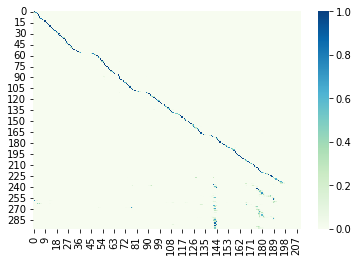

###########VALIDATION########
Prediction String:  IT WAS A MOST BURIED NOW AND FLOWERS AND FORLIAGE
Prediction String_len:  49
Labels_string:  <sos>IT WAS ALMOST BURIED NOW IN FLOWERS AND FOLIAGE
Len_label_string:  52
Prediction String:  THE OLD WOMAN BEHAVED VERY KILLEY TO THEM BUT IN REALITY SHE WAS OBICATED OLD WHICH WHO WAY LATE CHILDREN AND DILT THE BREAD HOUSE IN ORDER TO ENTICE THE MEN BUT AS SOON AS THEY WERE IN HER POWER SHE KILLED THEM COOKED THEM ANYTHEM AND MADE A GREAT FESTABLE OF THE DAY
Prediction String_len:  268
Labels_string:  <sos>THE OLD WOMAN BEHAVED VERY KINDLY TO THEM BUT IN REALITY SHE WAS A WICKED OLD WITCH WHO WAY LAID CHILDREN AND BUILT THE BREADHOUSE IN ORDER TO ENTICE THEM IN BUT AS SOON AS THEY WERE IN HER POWER SHE KILLED THEM COOKED AND ATE THEM AND MADE A GREAT FESTIVAL OF THE DAY
Len_label_string:  273
Prediction String:  THE QUING ASED UPON OUR FRIENDS WITHOUT IT INTEREST
Prediction String_len:  51
Labels_string:  <sos>THE QUEEN GAZED UPON OUR FRIENDS

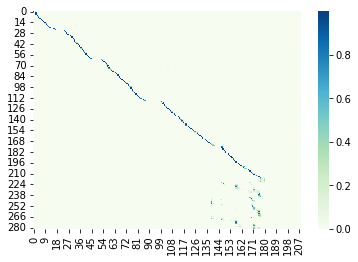

########### EPOCH: 24 ################
#########TRAINING##########
Learning rate:  0.002
teacher_forcing:  1 True
Train Loss:  tensor(0.0844, device='cuda:0')


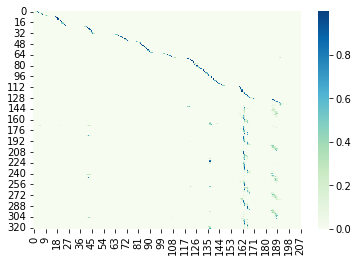

###########VALIDATION########
Prediction String:  A SPERIOR CELLED QUOOK THE ASSPARICAS INSULTED WATER DRAIN AND CHILL
Prediction String_len:  68
Labels_string:  <sos>ASPARAGUS SALAD COOK THE ASPARAGUS IN SALTED WATER DRAIN AND CHILL
Len_label_string:  71
Prediction String:  IN MIGHT JUST AS WELL BE SOME ONE ELSE'S WEDDING SO UNIMPORTANT IS THE PART WHICH I AM SET TO PLAY IN IT
Prediction String_len:  104
Labels_string:  <sos>IT MIGHT JUST AS WELL BE SOME ONE ELSE'S WEDDING SO UNIMPORTANT IS THE PART WHICH I AM SET TO PLAY IN IT
Len_label_string:  109
Prediction String:  THEREFORE MY ANSWER IS WITH GREATER CARE THAT HE MAY HEAR ME WHOSE WEEPING YONDER SO THAT THE SIN AND DULL BE OF ONE MEASURE
Prediction String_len:  124
Labels_string:  <sos>THEREFORE MY ANSWER IS WITH GREATER CARE THAT HE MAY HEAR ME WHO IS WEEPING YONDER SO THAT THE SIN AND DOLE BE OF ONE MEASURE
Len_label_string:  130
Prediction String:  BERSKIN WAS ROUND TO AND IN HER JEEKS SHE HAD A GLOW OF RICH DARK COLOR
Predict

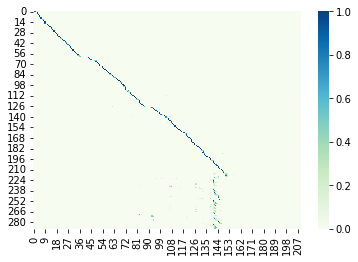

########### EPOCH: 26 ################
#########TRAINING##########
Learning rate:  0.002
teacher_forcing:  1 True
Train Loss:  tensor(0.0828, device='cuda:0')


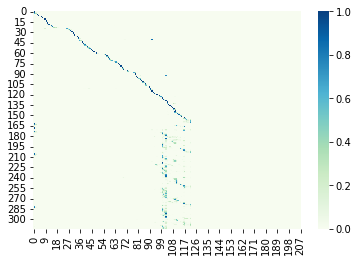

###########VALIDATION########
Prediction String:  EVEN THE CHANCE OF SUCCESSFULLY CONFIDING HER TO BEND AT EXPROTECTION HAD LOST SOMETHING OF ITS FAIR PROMISE SINCE RANDALLS PHYSIC TO SIDE THEM
Prediction String_len:  143
Labels_string:  <sos>EVEN THE CHANCE OF SUCCESSFULLY CONFIDING HER TO BENNYDECK'S PROTECTION HAD LOST SOMETHING OF ITS FAIR PROMISE SINCE RANDAL'S VISIT TO SYDENHAM
Len_label_string:  148
Prediction String:  WHEN AT LAST I REACHED CROFT IN MY JOURNEY THEN ET TURN NOT THE PESTATION STAFF CONSISTED OF A HALF WITH A INDIVIDUAL BLEW WAS STATIONED MASTER PORTER AND CLERK COMBINED AND A HULKING LED WHO DID WHATEVER ELSE THERE WAS TO DO
Prediction String_len:  225
Labels_string:  <sos>WHEN AT LAST I REACHED CROFTON MY JOURNEY'S END IT TURNED OUT THAT THE STATION STAFF CONSISTED OF A HALF WITTED INDIVIDUAL WHO WAS STATIONMASTER PORTER AND CLERK COMBINED AND A HULKING LAD WHO DID WHATEVER ELSE THERE WAS TO DO
Len_label_string:  231
Prediction String:  THE HOSPITALITY OF THE WI

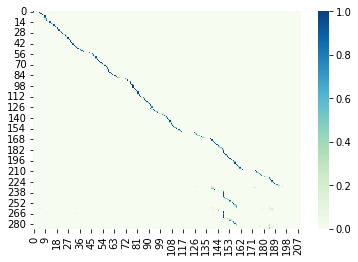

########### EPOCH: 28 ################
#########TRAINING##########
Learning rate:  0.002
teacher_forcing:  1 True
Train Loss:  tensor(0.0770, device='cuda:0')


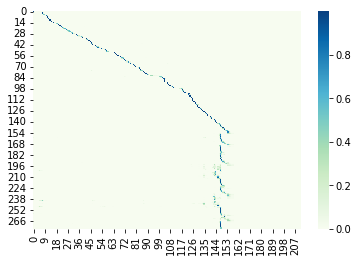

###########VALIDATION########
Prediction String:  HE HAD SEEN BREAK THINGS AND HE HAD DONE HIS SHARE OF THEM
Prediction String_len:  58
Labels_string:  <sos>HE HAD SEEN GREAT THINGS AND HE HAD DONE HIS SHARE OF THEM
Len_label_string:  63
Prediction String:  WHATEVER REVIVING AFFECTED MIGHT OTHERWAS HAD PRODUCED ON HIM IT MADE NO CHANGE IN THE THREATENING GLOOM OF THIS MANNER
Prediction String_len:  119
Labels_string:  <sos>WHATEVER REVIVING EFFECT IT MIGHT OTHERWISE HAVE PRODUCED ON HIM IT MADE NO CHANGE IN THE THREATENING GLOOM OF HIS MANNER
Len_label_string:  126
Prediction String:  NEVER USE NEW BREAD FOR MAKING ANY KIND OF TOAST AS IT EATS HEAVY AND BESIDES DISVERY EXTRAVAGANCE
Prediction String_len:  98
Labels_string:  <sos>NEVER USE NEW BREAD FOR MAKING ANY KIND OF TOAST AS IT EATS HEAVY AND BESIDES IS VERY EXTRAVAGANT
Len_label_string:  102
Prediction String:  I THOUGHT THAT WAS THE WAY TO BEGIN
Prediction String_len:  35
Labels_string:  <sos>I THOUGHT THAT WAS THE WAY TO BEGIN


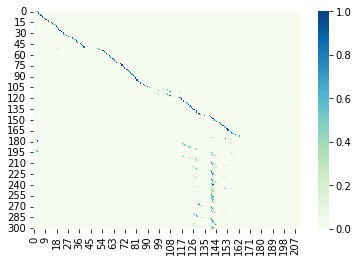

########### EPOCH: 30 ################
#########TRAINING##########
Learning rate:  0.002
teacher_forcing:  1 True
Train Loss:  tensor(0.0734, device='cuda:0')


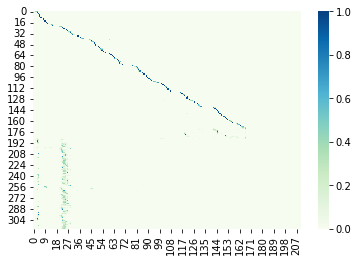

###########VALIDATION########
Prediction String:  THE LAST STREAMS OF THE ILL TREATED ILL FATED INTO MEZIL HAD DIED AWAY AND AFTER THEM HAD NIGHT AWAY ALSO THE RUMBLING OF THE WHEELS OF THE MURDEROUS FAREL ORGAN THAN IT SO GAILY EXECUTED THAT ALONG WITH THE NINE OTHER TUNES OF ITS REPATORY TO THE ADMIRATION OF THE HOUSE NADE AT THE WINDOW OF THE HOUSE OPPOSITE AND THE CROWING DELIGHT OF THE TWO BABIES NEXT DOOR
Prediction String_len:  364
Labels_string:  <sos>THE LAST STRAINS OF THE ILL TREATED ILL FATED INTERMEZZO HAD DIED AWAY AND AFTER THEM HAD DIED AWAY ALSO THE RUMBLING OF THE WHEELS OF THE MURDEROUS BARREL ORGAN THAT HAD SO GAILY EXECUTED THAT ALONG WITH THE NINE OTHER TUNES OF ITS REPERTORY TO THE ADMIRATION OF THE HOUSEMAID AT THE WINDOW OF THE HOUSE OPPOSITE AND THE CROWING DELIGHT OF THE TWO BABIES NEXT DOOR
Len_label_string:  370
Prediction String:  THE HOSPITALITY OF THE WIDOWNS ONLY LIMITED BY THE INSTITUTION OF WAR
Prediction String_len:  69
Labels_string:  <sos>THE HOSPI

KeyboardInterrupt: ignored

In [ ]:
#SAMPLE
n_epochs = 80

optimizer = optim.Adam(model.parameters(), lr = 0.002) #in paper ASGC(lr = 0.2, geometric_decay = 0.98)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2)# fill this out
criterion = nn.CrossEntropyLoss(reduction='none')
# optimizer = optim.Adam(model.parameters(), lr = 0.002)# fill this out)
# Make sure you understand the implication of setting reduction = 'none'
# criterion = nn.CrossEntropyLoss(reduction='none')
mode = 'train'

teacher_force_rate = 1
# teacher_reduce = (1-0.6)/n_epochs
for epoch in range(n_epochs): #stopped training after epoch 21 to change teacher forcinng rate
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    print('########### EPOCH:',epoch,'################')
    # mode = 'train'
    print('#########TRAINING##########')
    train(model, train_loader, criterion, optimizer, mode = 'train', teacher_forcing = True, teacher_rate =teacher_force_rate,epoch = epoch)
    # teacher_force_rate = teacher_force_rate *0.98
    
    if epoch%2 ==0:
      print('###########VALIDATION########')
      mode = 'eval'
      val(model, val_loader, mode = 'eval') 



In [ ]:
#SAMPLE DATA
# # TODO: Define your model and put it on the device here
# # ...

# n_epochs = 20
# optimizer = optim.Adam(model.parameters(), lr = 0.001)# fill this out)
# # Make sure you understand the implication of setting reduction = 'none'
# criterion = nn.CrossEntropyLoss(reduction='none')
# mode = 'train'

# teacher_force_rate = 1
# # teacher_reduce = (1-0.6)/n_epochs
# for epoch in range(n_epochs):
#     torch.cuda.empty_cache()
#     torch.cuda.empty_cache()
#     print('########### EPOCH:',epoch,'################')
    
#     #print('Mode = TRAIN')
#     train(model, train_loader_sample, criterion, optimizer, mode, teacher_forcing = True, teacher_rate =teacher_force_rate,epoch=epoch)
#     #teacher_force_rate = teacher_force_rate - teacher_reduce
#     # print('Mode = EVAL')
#     #mode = 'eval'
#     # val(model, train_loader_sample, criterion, mode) 

# TESTING

In [ ]:
torch.cuda.empty_cache()

In [ ]:
output = []
model.eval()
final_output = []

for i, (x,x_len) in enumerate(test_loader):
  #  print(x.shape)
   # print(x_len)

    x = x.cuda()
    predictions, attentions = model(x, x_len, mode = 'test', y =None, teacher_forcing = False,  teacher_rate = 0)
    batch_size = predictions.shape[0]


    final_pred = predictions.argmax(-1)


    for i in range(batch_size): 
        # h = h[i,1:-2]
        # y = y[i,1:-2]/

        h_list = []
        # print(i)

        for letter_ind in final_pred[i]:
          # print(letter_ind.item())
          if letter_ind.item() ==0:
            #print(0)
            continue
          elif letter_ind.item() ==29:
            break
          else:
            h_list.append(letter_ind.item())
            #print('here')
        
        #print(h_list)
        h_string = ""
        for x in h_list:
            h_string = h_string + index2letter[x] 
        #print(h_string)

        #break
        final_output.append(h_string)


In [ ]:
print(final_output[0])

HE BEGAN A CONFUSED COMPLAIT AGAINST THE WISZERT WHO ADVANISHED BEHIND THE CURT ON THE LEFT


In [ ]:
print(len(final_output))
with open("/content/attention.csv", "w+") as f:
    f.write("id,predictions\n")
    # print(len(test_dataset))
    # print(len(res))
    for i in range(len(final_output)):
        f.write("{},{}\n".format(str(i), final_output[i]))

2620
